In [1]:
# --- Python imports
from matplotlib.colors import Normalize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.stats import kde
import seaborn as sns

In [2]:
# --- Declare SDE
# dX = mu * X * dt + sigma * X * dW
mu = 1
sigma = 0.5
m0 = 1
P0 = 0.11

END_TIME = 3.
NUM_TSTEPS = 2**8

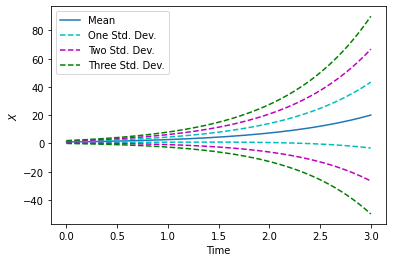

In [3]:
# --- Plot Known Mean and Variance Functions
def m(t, m0, mu):
    return m0 * np.exp(mu * t)

def variance(t, mu, sigma, m0, P0):
    return - m(t, m0, mu)**2 + (P0 + m0**2) * np.exp(t*(2*mu + sigma**2))

def two_sd(variance):
    return 2 * np.sqrt(variance)

time = np.linspace(0, END_TIME, NUM_TSTEPS)
mean = m(time, m0, mu)
std_dev = np.sqrt(variance(time, mu, sigma, m0, P0))

fig, ax = plt.subplots()
ax.plot(time, mean, label='Mean')
ax.plot(time, mean + std_dev, 'c--')
ax.plot(time, mean - std_dev, 'c--', label='One Std. Dev.')
ax.plot(time, mean + 2*std_dev, 'm--')
ax.plot(time, mean - 2*std_dev, 'm--', label='Two Std. Dev.')
ax.plot(time, mean + 3*std_dev, 'g--')
ax.plot(time, mean - 3*std_dev, 'g--', label='Three Std. Dev.')
ax.set_xlabel('Time')
ax.set_ylabel('$X$')
ax.legend()

In [4]:
# --- Brownian Motion
def multiple_brownian_motion(end_time=1., num_tsteps=500, n_trials=1000):
    """Creates multiple 1-D Brownian motion with time as the row index and
    each column as a separate path of Brownian motion.

    This assumes that all Brownian motion starts at 0. Currently only
    implements one-dimensional Brownian motion. This also assumes all
    step sizes are the same size.

    The steps of Brownian motion, ``dw``, are modeled with a Gaussian
    distribution with mean 0 and variance ``sqrt(dt)``, where ``dt``
    is the constant time step size.

    Parameters
    ----------
    end_time : float

    num_tsteps : int
        The number of steps to take. Will calculate the step
        size dt internally. The number of rows in the output of
        Brownian motion will be num_tsteps + 1.

    n_trials : int
        The number of sample paths to create. This will be the number
        of columns in the output.

    Returns
    -------
    t : ndarray
        One-dimensional time ndarray from 0 to ``end_time`` with
        shape (``num_tsteps``+1,)

    w : ndarray
        Two-dimensional ndarray representing ``n_trials`` number of
        sample paths of one-dimensional Brownian motion.
        This will be of shape (``num_tsteps``+1, ``n_trials``).

    dt : float
        The value indicating the step size of t. This is only implemented
        with constant step size.

    dw : ndarray
        Two-dimensional ndarray representing the steps of Brownian motion.
        The first row is all zeros. Each i-th row of ``dw``, ie. dw[i, :]
        indicates the change in ``w`` from w[i-1, :] to w[i, :]
        This will be the same shape as ``w``, (``num_tsteps``+1, ``n_trials``).

    """

    dt = (end_time - 0) / num_tsteps
    dw = np.random.normal(scale=np.sqrt(dt), size=(num_tsteps+1, n_trials))
    # Brownian motion must start at time 0 with value 0
    dw[0] = np.zeros_like(dw[0])
    w = dw.cumsum(axis=0)
    # t is not used in calculations, but returned to allow user to keep track
    # of points in time
    t = np.linspace(0, end_time, num=num_tsteps+1).reshape((num_tsteps+1, 1))
    assert w.shape[0] == t.shape[0], ('time and position arrays are not the '
                                      'same length. w.shape[0] - t.shape[0] = '
                                      f'{w.shape[0] - t.shape[0]}')
    assert w.shape == dw.shape, ('position and velocity arrays are not the '
                                 'same shape: '
                                 f'w.shape: {w.shape}    dw.shape: {dw.shape}')
    return t, w, dt, dw


def euler_maruyama_nonlinear_vec(f, g, x0, t, dt, dw, M):
    """
    calculates the EM approximation on the nonlinear one-dimensional SDE,
    vectorized for multiple trials based on the shape of ``dw``.

    SDE is of the form:
    dX = f(X)dt + G(X)dW; X(0) = X0

    :param f: shift function in SDE. Must be passed as a function of x
    :param g: drift/dispersion function in SDE
    :param x0: Initial condition
    :param t: time one dimensional nd-array
    :param dt: step size of time array, float
    :param dw: White noise associated with the Brownian motion, ndarray
    :param M: multiple of dt for Euler-Maruyama step size. Do not make this too large.
    :return: time array and solution x array
    """

    if M < 1:
        raise ValueError('M must be greater than or equal to 1')

    Dt = M * dt  # EM step size
    L = (t.shape[0] - 1) / M  # number of EM steps

    if not L.is_integer():
        raise ValueError('Cannot handle Step Size that is not a multiple of M')

    L = int(L)  # needed for range below

    x = [np.full((dw.shape[1],), x0)]
    T = [0]
    for i in range(1, L+1):
        # DW is the step of Brownian motion for EM step size
        DW = (dw[M * (i - 1) + 1:M * i + 1, :]).sum(axis=0).reshape(dw.shape[1], )
        x.append(x[i-1] + Dt * f(x[i-1]) + g(x[i-1]) * DW)
        T.append(T[i-1] + Dt)

    return np.array(T), np.array(x)


def plot_on_axis(ax, time, pos, cols, title, color_map, with_mean=False):
    for idx, col in enumerate(cols):
        ax.plot(time, pos[:, col], c=color_map(idx))
    ax.set_title(title)
    if with_mean:
        ax.plot(time, pos.mean(axis=1), color='black',
            label=r'Sample Mean $(n={})$'.format(pos.shape[1]), linewidth=2)
        ax.plot(time, pos.mean(axis=1) + 2* pos.std(axis=1), color='black',
                linestyle='dashed')
        ax.plot(time, pos.mean(axis=1) - 2* pos.std(axis=1), color='black',
                linestyle='dashed', label='Two Std. Dev.')
        ax.legend()


In [5]:
# -- Input Deck
# Parameters for SDE
def f(x):
    return mu * x

def g(x):
    return sigma * x

# Initial Condition
x0 = 1

# Brownian Motion
N_TRIALS = 1000
# END_TIME and NUM_TSTEPS assigned above

# Euler-Maruyama
M = 4  # multiple of step size

# Plotting Parameters
N_PATHS = 1000
viridis = plt.get_cmap('viridis', lut=N_PATHS)
columns = np.arange(N_PATHS)
np.random.shuffle(columns)
plot_columns = columns[:N_PATHS]


Text(0, 0.5, 'Value')

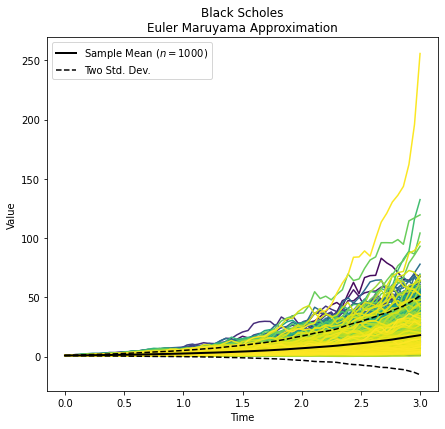

In [6]:
# -- Calculate
t, w, dt, dw = multiple_brownian_motion(end_time=END_TIME,
                                        num_tsteps=NUM_TSTEPS,
                                        n_trials=N_TRIALS)

t_em, x_em = euler_maruyama_nonlinear_vec(f, g, x0, t, dt, dw, M)

fig, ax = plt.subplots(1, figsize=(7, 6.5))
plot_on_axis(ax, t_em, x_em, plot_columns, 'Black Scholes\nEuler Maruyama Approximation',
             color_map=viridis, with_mean=True)
ax.set_xlabel('Time')
ax.set_ylabel('Value')


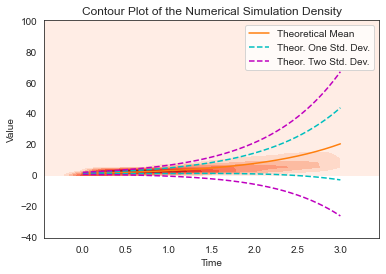

In [12]:
plt.figure()
data_points = pd.DataFrame({
    'Time': np.tile(t_em, N_TRIALS),
    'Value': x_em.flatten(order='F')
})

sns.set_style("white")
ax3 = sns.kdeplot(data_points['Time'], data_points['Value'],
                  cmap=plt.cm.gist_earth_r, shade=True, levels=1000)
ax3.plot(time, mean, color='black', label='Theoretical Mean')
ax3.plot(time, mean + std_dev, 'c--')
ax3.plot(time, mean - std_dev, 'c--', label='Theor. One Std. Dev.')
ax3.plot(time, mean + 2*std_dev, 'm--')
ax3.plot(time, mean - 2*std_dev, 'm--', label='Theor. Two Std. Dev.')
ax3.set_title('Contour Plot of the Numerical Simulation Density')
ax3.set_ylim(top=100)
ax3.legend()

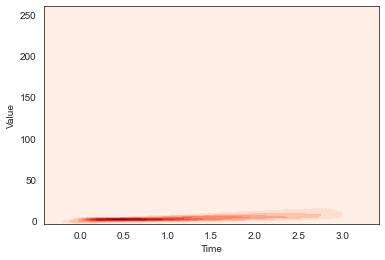

In [13]:
ax3 = sns.kdeplot(data_points['Time'], data_points['Value'],
                  cmap="Reds", shade=True)

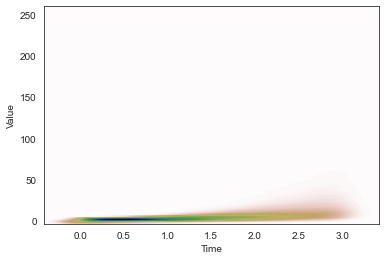

In [17]:
ax3 = sns.kdeplot(data_points['Time'], data_points['Value'],
                  cmap=plt.cm.gist_earth_r, shade=True, levels=400)

In [18]:
x_em.shape


(65, 1000)

In [19]:
t_em.shape


(65,)

In [20]:
from scipy.stats import gaussian_kde


In [26]:
row = x_em[10]

In [27]:
a = gaussian_kde(row)

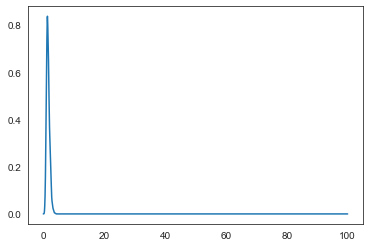

In [29]:
a.evaluate(np.linspace(0, 100, 10000))
plt.plot(np.linspace(0, 100, 10000), a.evaluate(np.linspace(0, 100, 10000)))

In [45]:
pdf_rows = []
x_for_pdf = np.linspace(0, 100, 10000)
for idx, row in enumerate(x_em[1:]):
    row_kde = gaussian_kde(row)
    row_pdf = row_kde.evaluate(x_for_pdf)
    pdf_rows.append(row_pdf / max(row_pdf))

In [46]:
pdf_rows = np.array(pdf_rows)

In [47]:
pdf_rows.shape

(64, 10000)

In [48]:
x_for_pdf.shape

(10000,)

In [49]:
t_em[1:].shape

(64,)

In [50]:
tt, xx = np.meshgrid(t_em[1:], x_for_pdf)

In [51]:
print(tt.shape)
print(pdf_rows.shape)

(10000, 64)
(64, 10000)


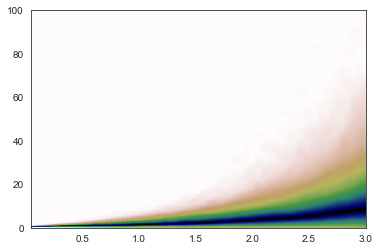

In [53]:
fig, ax = plt.subplots()
ax.pcolormesh(tt, xx, pdf_rows.T, shading='gouraud', cmap=plt.cm.gist_earth_r)
